In [3]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU,LeakyReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam,SGD

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    #bn = BatchNormalization()(relu)
    return relu

#Defining Residual Block
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,strides= (1 if not downsample else 2),filters=filters,padding="same",kernel_initializer = glorot_uniform(seed=0))(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,strides=1,filters=filters,padding="same",kernel_initializer = glorot_uniform(seed=0))(y)

    if downsample:
        x = Conv2D(kernel_size=1,strides=2,filters=filters,padding="same",kernel_initializer = glorot_uniform(seed=0))(x)

    out = Add()([x, y])
    out = relu_bn(out)
    return out

#Defining ResNet Block
def create_res_net():
    
    inputs = Input(shape=(32, 32, 3))
    num_filters = 64
    
    #t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,strides=1,filters=num_filters,padding="same",kernel_initializer = glorot_uniform(seed=0))(inputs)
    t = relu_bn(t)
    
    num_blocks_list = [2,2, 2,2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    t = Dense(512,activation='relu')(t)
    outputs = Dense(100, activation='softmax')(t)
    
    model = Model(inputs, outputs)
    adam=Adam(learning_rate=0.0001,clipnorm=1,name='adam')
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

    return model

Code snippet taken and modified from https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

In [4]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard,EarlyStopping
import datetime
import os

(x_train, Y_train), (x_test, Y_test) = cifar100.load_data()
from keras.utils import to_categorical
y_train = to_categorical(Y_train,100)
y_test = to_categorical(Y_test,100)

model = create_res_net()
model.summary()

from keras.preprocessing.image import ImageDataGenerator
aug_data=ImageDataGenerator(
        rotation_range=20,     #randomly rotate images in the range (20 degrees)
        horizontal_flip=True,  #randomly flip images
        width_shift_range=0.1, #randomly shift images horizontally (fraction of total width)
        shear_range = 0.2,     #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
        height_shift_range=0.1,#randomly shift images vertically (fraction of total height)
        zoom_range=0.2,        #Range for random zoom
        brightness_range = (0.5, 1.5))   #Range for picking a brightness shift value
aug_data.fit(x_train)

# save model after each epoch
checkpoint = ModelCheckpoint("ResNet_Basic_Adam.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto',restore_best_weights=True)
hist=model.fit(aug_data.flow(x_train, y_train, batch_size=128), batch_size=128, epochs=70, verbose=1, validation_data=(x_test, y_test),callbacks=[early,checkpoint])


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
re_lu_17 (ReLU)                 (None, 32, 32, 64)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 64)   36928       re_lu_17[0][0]                   
_______________________________________________________________________________________

In [5]:

# Test the model
y_true = y_test.argmax(-1)
y_pred = model.predict(x_test).argmax(-1)
# generate confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
confusion_matrix(y_true, y_pred)
# calculate prec, recall, accuracy
print("Prec: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Prec: 0.5740739259190092
Recall: 0.5535
Accuracy: 0.5535


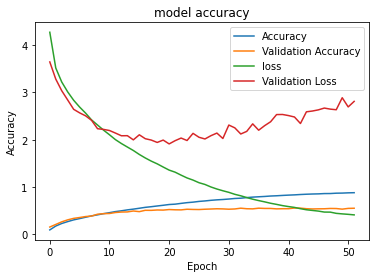

In [6]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## Cell to Load Weights and Print Results

In [1]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU,LeakyReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard,EarlyStopping

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    #bn = BatchNormalization()(relu)
    return relu

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,strides= (1 if not downsample else 2),filters=filters,padding="same",kernel_initializer = glorot_uniform(seed=0))(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,strides=1,filters=filters,padding="same",kernel_initializer = glorot_uniform(seed=0))(y)

    if downsample:
        x = Conv2D(kernel_size=1,strides=2,filters=filters,padding="same",kernel_initializer = glorot_uniform(seed=0))(x)

    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(32, 32, 3))
    num_filters = 64
    
    #t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,strides=1,filters=num_filters,padding="same",kernel_initializer = glorot_uniform(seed=0))(inputs)
    t = relu_bn(t)
    
    num_blocks_list = [2,2, 2,2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    t = Dense(512,activation='relu')(t)
    outputs = Dense(100, activation='softmax')(t)
    
    model = Model(inputs, outputs)
    adam=Adam(learning_rate=0.0001,clipnorm=1,name='adam')
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

    return model





(x_train, Y_train), (x_test, Y_test) = cifar100.load_data()
#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255
from keras.utils import to_categorical
y_train = to_categorical(Y_train,100)
y_test = to_categorical(Y_test,100)

model = create_res_net() # or create_plain_net()




model.load_weights('../weights/ResNet_Basic_Adam.hdf5')


# Test the model
y_true = y_test.argmax(-1)
y_pred = model.predict(x_test).argmax(-1)
# generate confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
confusion_matrix(y_true, y_pred)
# calculate prec, recall, accuracy
print("Prec: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Using TensorFlow backend.


Prec: 0.5740739259190092
Recall: 0.5535
Accuracy: 0.5535
